In [13]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import sys
sys.path.append("../")

import pandas
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from src.utils.eye_tracking_data import (
    get_eye_tracking_data,
    with_time_since_start_column,
    with_time_since_last_column,
    with_distance_since_last_column,
    with_speed_since_last_column,
)
from src.config import RAW_EYE_TRACKING_FRAME_WIDTH, RAW_EYE_TRACKING_FRAME_HEIGHT

N_NANOSECONDS_IN_SECOND = 1e9  # Number of nanoseconds in a second
OUTPUT_FILE_PATH = "../data/result.mp4"

## Loading Processed Data

In [15]:
data = get_eye_tracking_data()
data = with_time_since_start_column(data)
data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,GazeX_sc,GazeY_sc,GazeX_px,GazeY_px,Timestamp_ns,TimeSinceStart_ns
0,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345543344252,0.0
1,1,1,1,1,0.739250,0.870603,4541.9500,2674.4930,8492802345801721952,258377700.0
2,1,1,1,1,0.680598,0.649704,4181.5950,1995.8899,8492802345847617152,304272900.0
3,1,1,1,1,0.663174,0.657053,4074.5400,2018.4670,8492802345951811152,408466900.0
4,1,1,1,1,0.548628,0.777003,3370.7708,2386.9520,8492802346058247252,514903000.0


In [16]:
interpolated_data = get_eye_tracking_data(interpolated=True)
interpolated_data = with_time_since_start_column(interpolated_data)
interpolated_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,GazeX_sc,GazeY_sc,GazeX_px,GazeY_px,Timestamp_ns,TimeSinceStart_ns
0,1,1,1,1,0.813762,0.661315,4999.7515,2031.5590,8492802345500000000,0.0
1,1,1,1,1,0.796455,0.677788,4893.4220,2082.1643,8492802345550000000,50000000.0
2,1,1,1,1,0.779149,0.694261,4787.0920,2132.7698,8492802345600000000,100000000.0
3,1,1,1,1,0.761843,0.710734,4680.7617,2183.3752,8492802345650000000,150000000.0
4,1,1,1,1,0.744536,0.727207,4574.4320,2233.9805,8492802345700000000,200000000.0


In [17]:
fixation_data = get_eye_tracking_data(fixation=True)
fixation_data.head()

,ExperimentId,SessionId,ParticipantId,SequenceId,FixationX_sc,FixationY_sc,FixationX_px,FixationY_px,StartTimestamp_ns,EndTimestamp_ns,Duration_ns
0,1,1,1,1,0.554362,0.786974,3405.9980,2417.5833,8492802346100000000,8492802346250000000,150000000
1,1,1,1,1,0.487500,0.740497,2995.1987,2274.8070,8492802346250000000,8492802346450000000,200000000
2,1,1,1,1,0.465374,0.713988,2859.2593,2193.3720,8492802346450000000,8492802346650000000,200000000
3,1,1,1,1,0.543525,0.746215,3339.4167,2292.3720,8492802346750000000,8492802346900000000,150000000
4,1,1,1,1,0.297791,0.731408,1829.6268,2246.8853,8492802347600000000,8492802347800000000,200000000


## Number of Data Points Over Time

In [209]:
def plot_number_data_points_over_time(
    data: pd.DataFrame,
) -> None:
    """
    Plot the data points over time.

    Args:
        data (pandas.DataFrame): The data to plot.
    """
    # Convert the time to seconds
    data = data.copy()
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )
    data = data.groupby(["Legend", "TimeSinceStart_s"]).size().reset_index(name="count")

    # Update data to fit the plot
    pivot_data = data.pivot(
        index="TimeSinceStart_s", columns="Legend", values="count"
    ).fillna(0)

    # Plot the histogram
    pivot_data.plot(kind="bar", stacked=True, figsize=(10, 6), width=1)
    plt.xlabel("Time (s)")
    plt.xticks(range(0, pivot_data.index.max(), 15))
    plt.ylabel("Number of data points")
    plt.title("Number of data points over time")
    plt.legend()
    plt.tight_layout()
    plt.show()

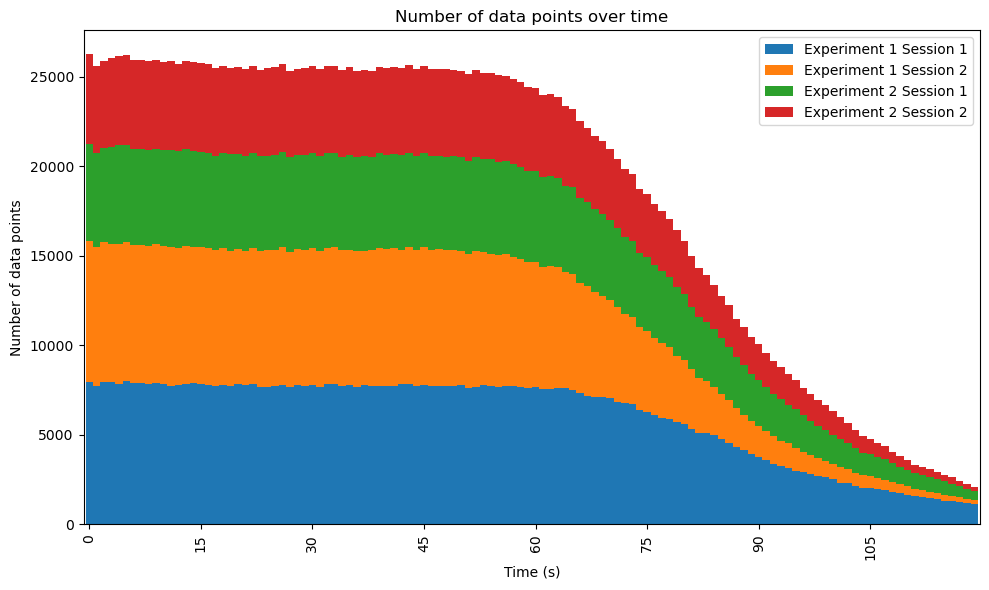

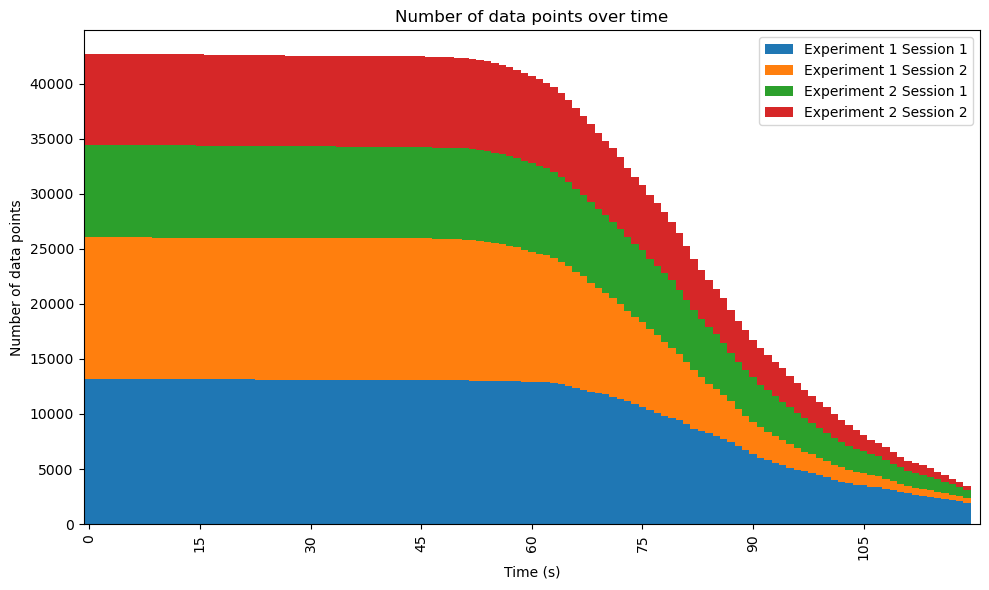

In [210]:
plot_number_data_points_over_time(data)
plot_number_data_points_over_time(interpolated_data)

## Gaze Time Distribution

In [245]:
def plot_gaze_time(data: pd.DataFrame, remove_outliers: bool = True) -> None:
    """
    Plot the time since the last gaze point distribution.

    Args:
        data (pd.DataFrame): The data to plot.
        remove_outliers (bool, optional): Whether to remove outliers. Defaults to True.
    """
    # Add the time since last gaze point column
    data = data.copy()
    data = with_time_since_last_column(data)
    data["Experiment_Session"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    data = data.copy()
    if remove_outliers:
        q_low = data["TimeSinceLast_ns"].quantile(0.05)
        q_hi = data["TimeSinceLast_ns"].quantile(0.95)
        data = data[
            (data["TimeSinceLast_ns"] < q_hi) & (data["TimeSinceLast_ns"] > q_low)
        ]

    # Plot histogram
    sns.histplot(
        data=data,
        x="TimeSinceLast_ns",
        hue="Experiment_Session",
        bins=50,
        log_scale=True,
    )
    plt.xlabel("Time since last gaze point (ns)")
    plt.ylabel("Number of data points")
    plt.title(
        f"Time since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    sns.boxplot(
        data=data,
        x="ExperimentId",
        y="TimeSinceLast_ns",
        hue="SessionId",
    )
    plt.xlabel("Experiment")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(
        f"Time since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    # Print median and mean
    print(f"Median: {data.groupby('Experiment_Session')['TimeSinceLast_ns'].median()}")
    print(f"Mean: {data.groupby('Experiment_Session')['TimeSinceLast_ns'].mean()}")

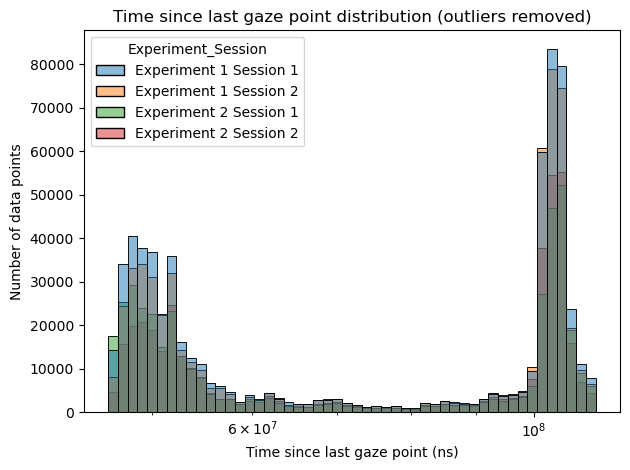

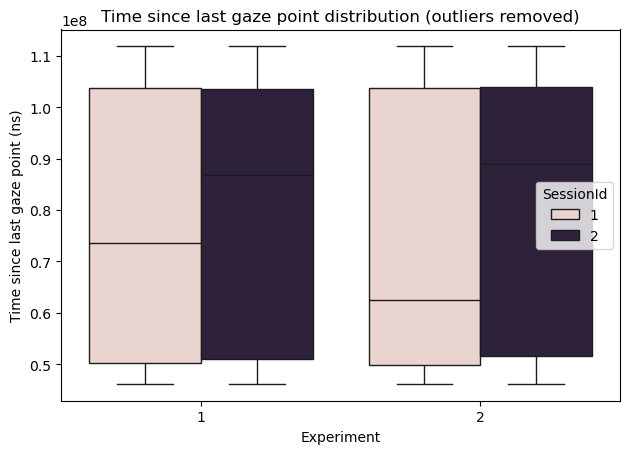

Median: Experiment_Session
Experiment 1 Session 1    73691700.0
Experiment 1 Session 2    86769350.0
Experiment 2 Session 1    62558800.0
Experiment 2 Session 2    88886050.0
Name: TimeSinceLast_ns, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    7.709724e+07
Experiment 1 Session 2    7.842095e+07
Experiment 2 Session 1    7.529509e+07
Experiment 2 Session 2    7.895683e+07
Name: TimeSinceLast_ns, dtype: float64


In [246]:
plot_gaze_time(data, remove_outliers=True)

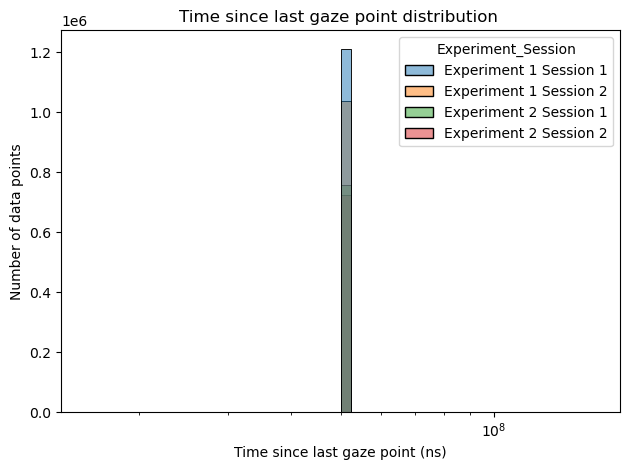

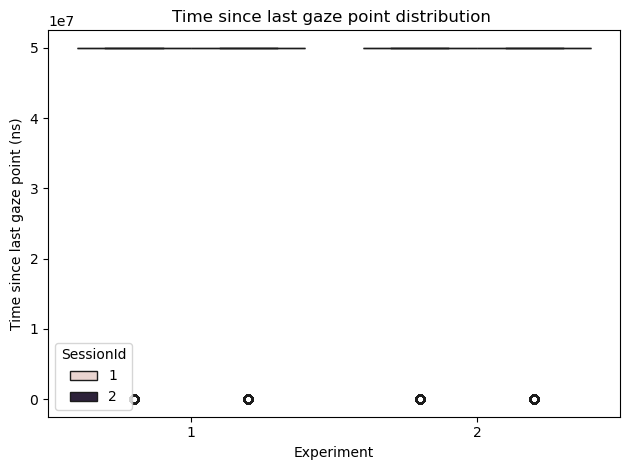

Median: Experiment_Session
Experiment 1 Session 1    50000000.0
Experiment 1 Session 2    50000000.0
Experiment 2 Session 1    50000000.0
Experiment 2 Session 2    50000000.0
Name: TimeSinceLast_ns, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    4.997291e+07
Experiment 1 Session 2    4.996896e+07
Experiment 2 Session 1    4.997234e+07
Experiment 2 Session 2    4.997144e+07
Name: TimeSinceLast_ns, dtype: float64


In [247]:
plot_gaze_time(interpolated_data, remove_outliers=False)

## Gaze Distance Distribution

In [249]:
def plot_gaze_distance(data: pd.DataFrame, remove_outliers: bool = True) -> None:
    """
    Plot the distance since the last gaze point distribution.

    Args:
        data (pd.DataFrame): The data to plot.
        remove_outliers (bool, optional): Whether to remove outliers. Defaults to True.
    """
    # Add the distance since last gaze point column
    data = data.copy()
    data = with_distance_since_last_column(data)
    data["Experiment_Session"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    data = data.copy()
    if remove_outliers:
        q_low = data["DistanceSinceLast_px"].quantile(0.05)
        q_hi = data["DistanceSinceLast_px"].quantile(0.95)
        data = data[
            (data["DistanceSinceLast_px"] < q_hi)
            & (data["DistanceSinceLast_px"] > q_low)
        ]

    # Plot histogram
    sns.histplot(
        data=data,
        x="DistanceSinceLast_px",
        hue="Experiment_Session",
        bins=50,
        log_scale=True,
    )
    plt.xlabel("Distance since last gaze point (px)")
    plt.ylabel("Number of data points")
    plt.title(
        f"Distance since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    sns.boxplot(
        data=data,
        x="ExperimentId",
        y="DistanceSinceLast_px",
        hue="SessionId",
    )
    plt.xlabel("Experiment")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(
        f"Distance since last gaze point distribution {'(outliers removed)' if remove_outliers else ''}"
    )
    plt.tight_layout()
    plt.show()

    # Print median and mean
    print(
        f"Median: {data.groupby('Experiment_Session')['DistanceSinceLast_px'].median()}"
    )
    print(f"Mean: {data.groupby('Experiment_Session')['DistanceSinceLast_px'].mean()}")

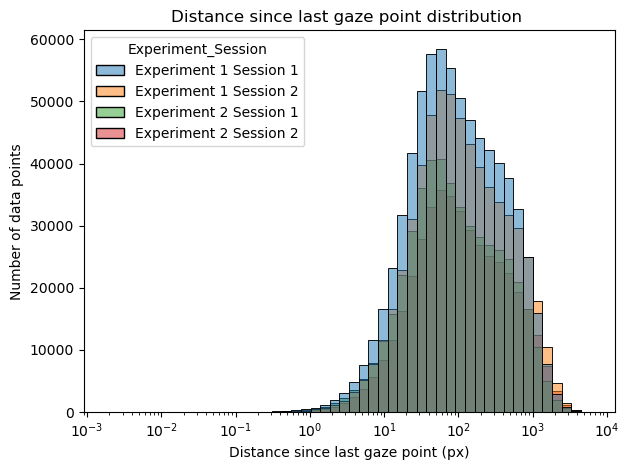

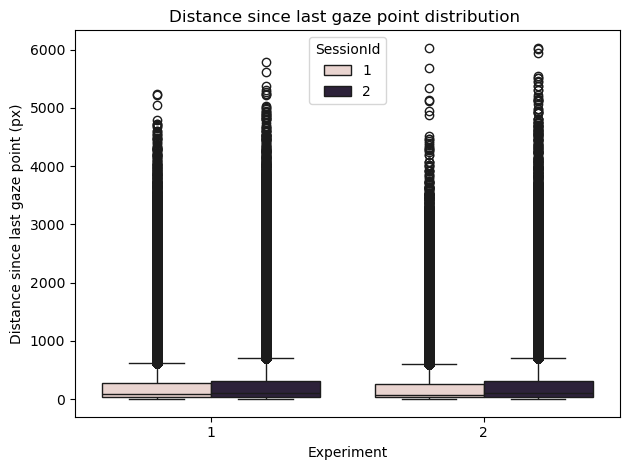

Median: Experiment_Session
Experiment 1 Session 1    85.702677
Experiment 1 Session 2    98.843907
Experiment 2 Session 1    79.707880
Experiment 2 Session 2    97.611886
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    222.884453
Experiment 1 Session 2    259.519388
Experiment 2 Session 1    216.960287
Experiment 2 Session 2    259.584030
Name: DistanceSinceLast_px, dtype: float64


In [250]:
plot_gaze_distance(data, remove_outliers=False)

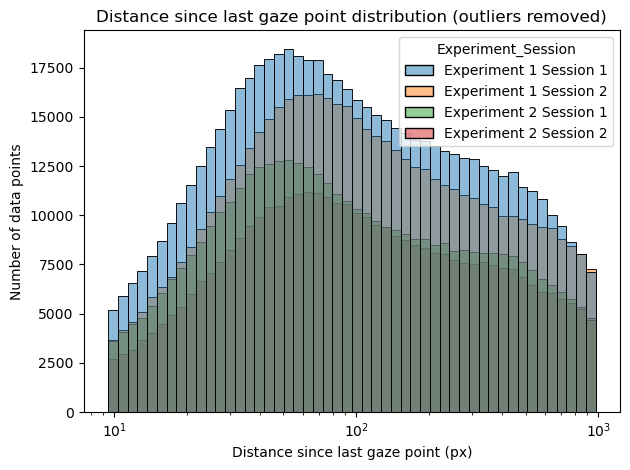

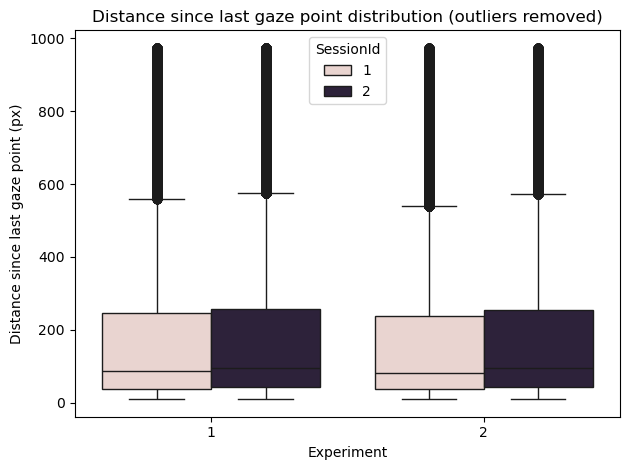

Median: Experiment_Session
Experiment 1 Session 1    88.010384
Experiment 1 Session 2    95.704628
Experiment 2 Session 1    82.459672
Experiment 2 Session 2    94.510016
Name: DistanceSinceLast_px, dtype: float64
Mean: Experiment_Session
Experiment 1 Session 1    182.067933
Experiment 1 Session 2    191.017913
Experiment 2 Session 1    177.589694
Experiment 2 Session 2    188.651607
Name: DistanceSinceLast_px, dtype: float64


In [251]:
plot_gaze_distance(data, remove_outliers=True)

## Gaze Speed Distribution

In [252]:
def plot_gaze_speed(
    data: pd.DataFrame,
    bins: int = 50,
) -> None:
    # Add the speed since last gaze point column
    data = data.copy()
    data = with_speed_since_last_column(data)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Plot histogram
    sns.histplot(
        data=data,
        x="SpeedSinceLast_pxs",
        hue="Legend",
        bins=bins,
        log_scale=True,
    )
    plt.xlabel("Speed since last gaze point (px)")
    plt.ylabel("Number of data points")
    plt.title(f"Speed since last gaze point distribution")
    plt.tight_layout()
    plt.show()

    # Plot box plot
    sns.boxplot(
        data=data,
        x="ExperimentId",
        y="SpeedSinceLast_pxs",
        hue="SessionId",
        showfliers=False,
    )
    plt.xlabel("Experiment")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.title(f"Box plot of mean speeds since last gaze point over sequences")
    plt.tight_layout()
    plt.show()

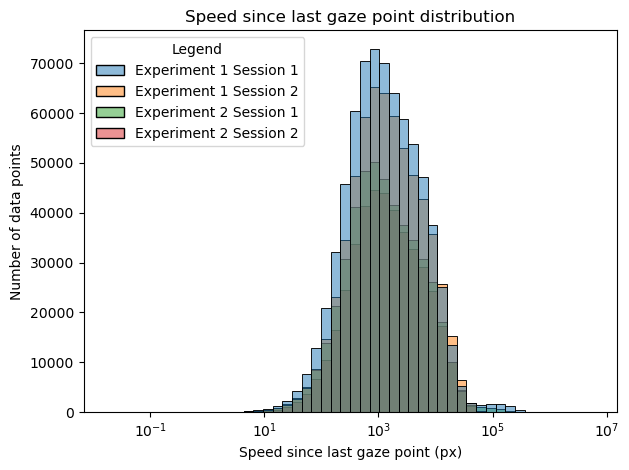

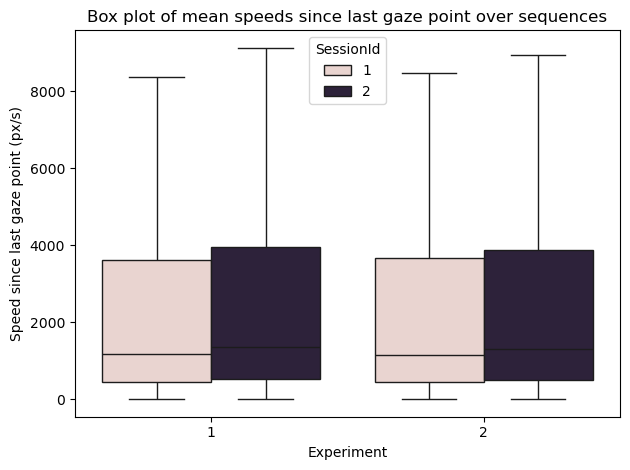

In [253]:
plot_gaze_speed(data)

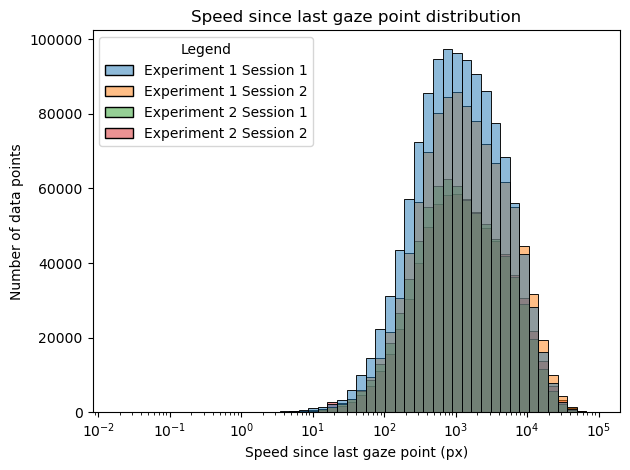

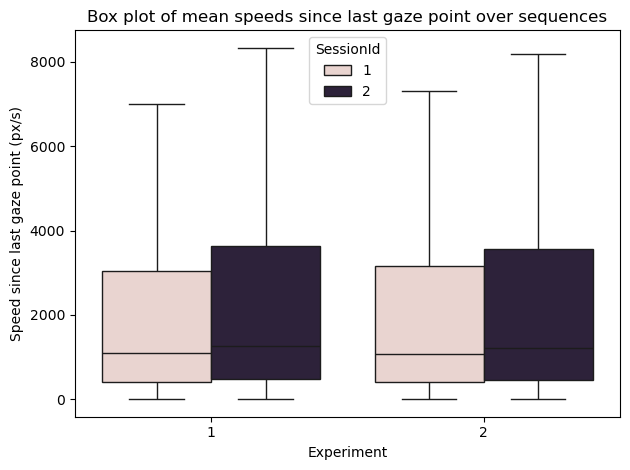

In [254]:
plot_gaze_speed(interpolated_data)

## Gaze Distance and Time Over Time

In [238]:
def plot_gaze_distance_time_over_time(
    data: pd.DataFrame,
    remove_outliers: bool = True,
) -> None:
    # Add the time and distance since last gaze point column
    data = data.copy()
    data = with_time_since_last_column(data)
    data = with_distance_since_last_column(data)
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Remove outliers based on quantiles
    if remove_outliers:
        q_low = data["TimeSinceLast_ns"].quantile(0.05)
        q_hi = data["TimeSinceLast_ns"].quantile(0.95)
        data = data[
            (data["TimeSinceLast_ns"] < q_hi) & (data["TimeSinceLast_ns"] > q_low)
        ]
        q_low = data["DistanceSinceLast_px"].quantile(0.05)
        q_hi = data["DistanceSinceLast_px"].quantile(0.95)
        data = data[
            (data["DistanceSinceLast_px"] < q_hi)
            & (data["DistanceSinceLast_px"] > q_low)
        ]

    # Plot the time and distance since last gaze point over time for all sessions
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="TimeSinceLast_ns",
        errorbar=('ci', 95),
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(f"Mean time since last gaze point of all sections over time")
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="DistanceSinceLast_px",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(f"Mean distance since last gaze point of all sections over time")
    plt.suptitle(f"Mean time and distance since last gaze point of all sections over time (95% CI)")
    plt.tight_layout()
    plt.show()

    # Plot the time and distance since last gaze point over time for each session
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 1, 1)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="TimeSinceLast_ns",
        errorbar=('ci', 95),
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Time since last gaze point (ns)")
    plt.title(f"Mean time since last gaze point of each session over time (95% CI)")
    plt.subplot(2, 1, 2)
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="DistanceSinceLast_px",
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Distance since last gaze point (px)")
    plt.title(f"Mean distance since last gaze point of each session over time")
    plt.suptitle(f"Mean time and distance since last gaze point of each session over time (95% CI)")
    plt.tight_layout()
    plt.show()

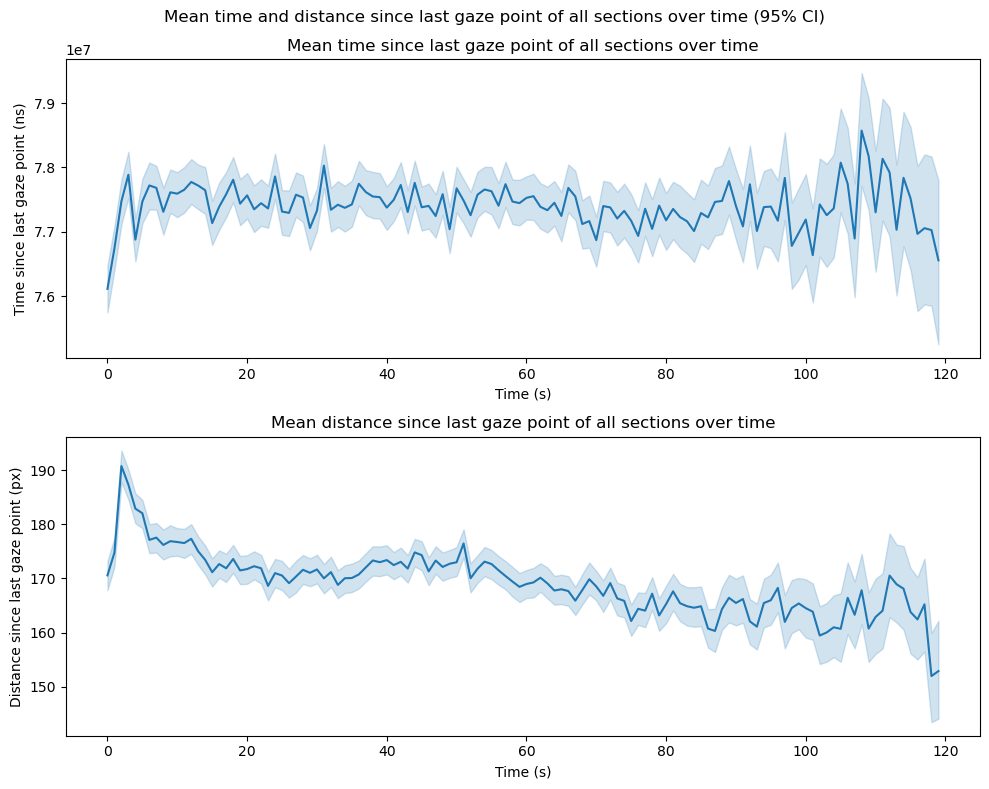

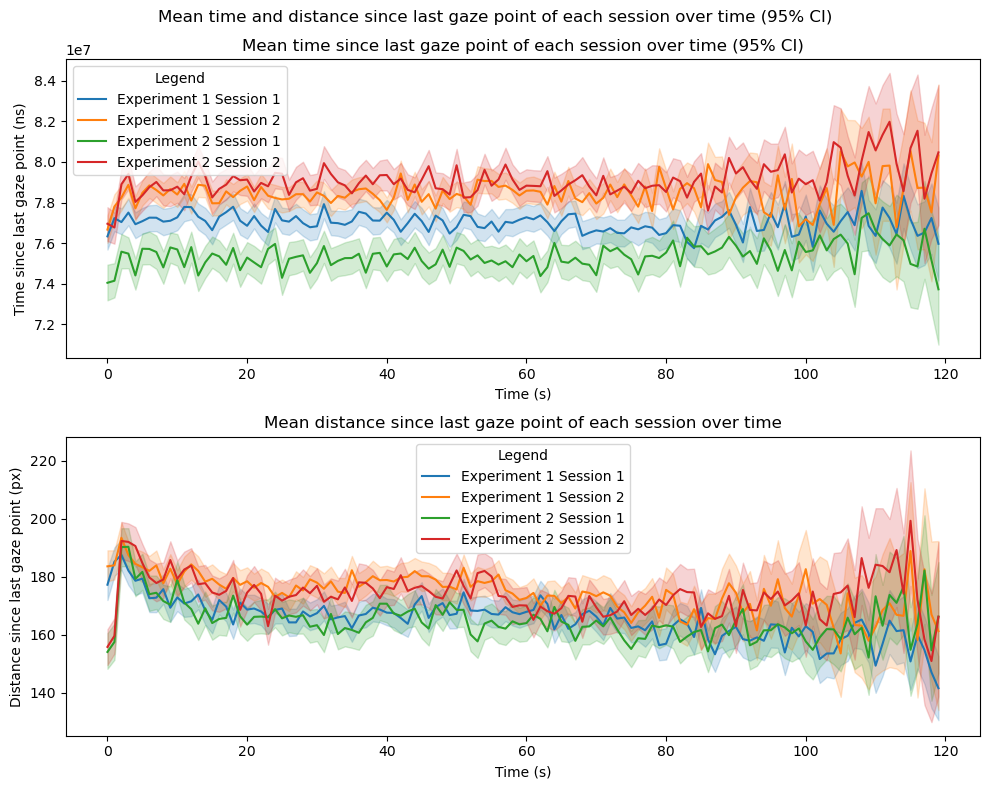

In [239]:
plot_gaze_distance_time_over_time(data, remove_outliers=True)

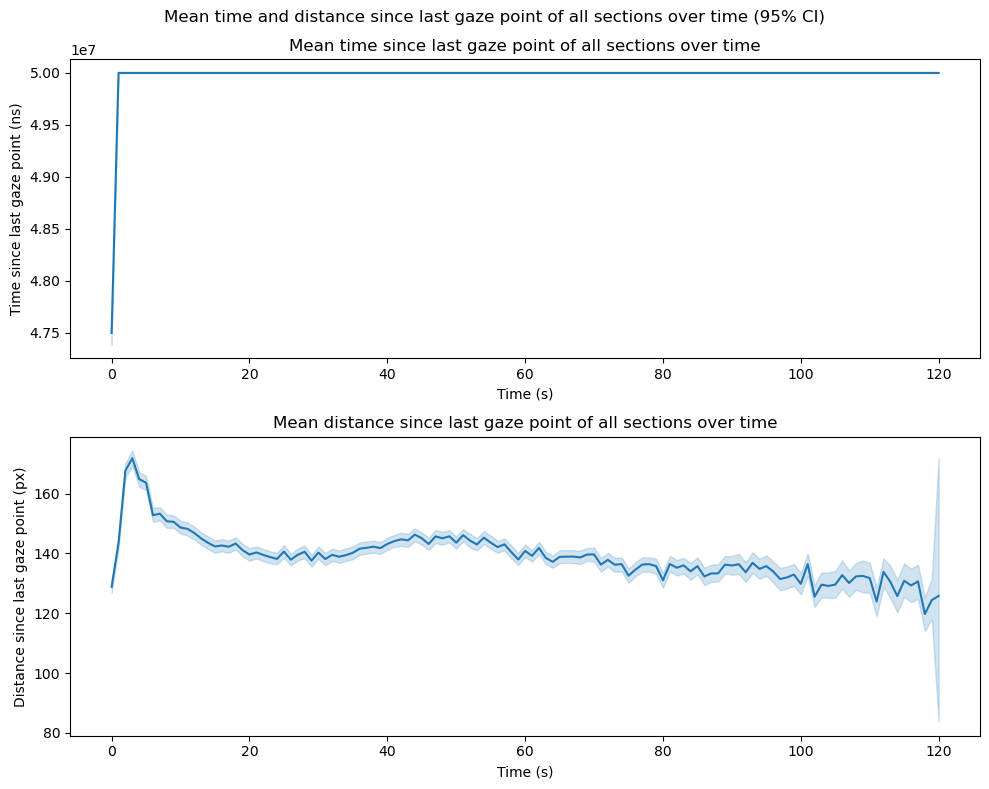

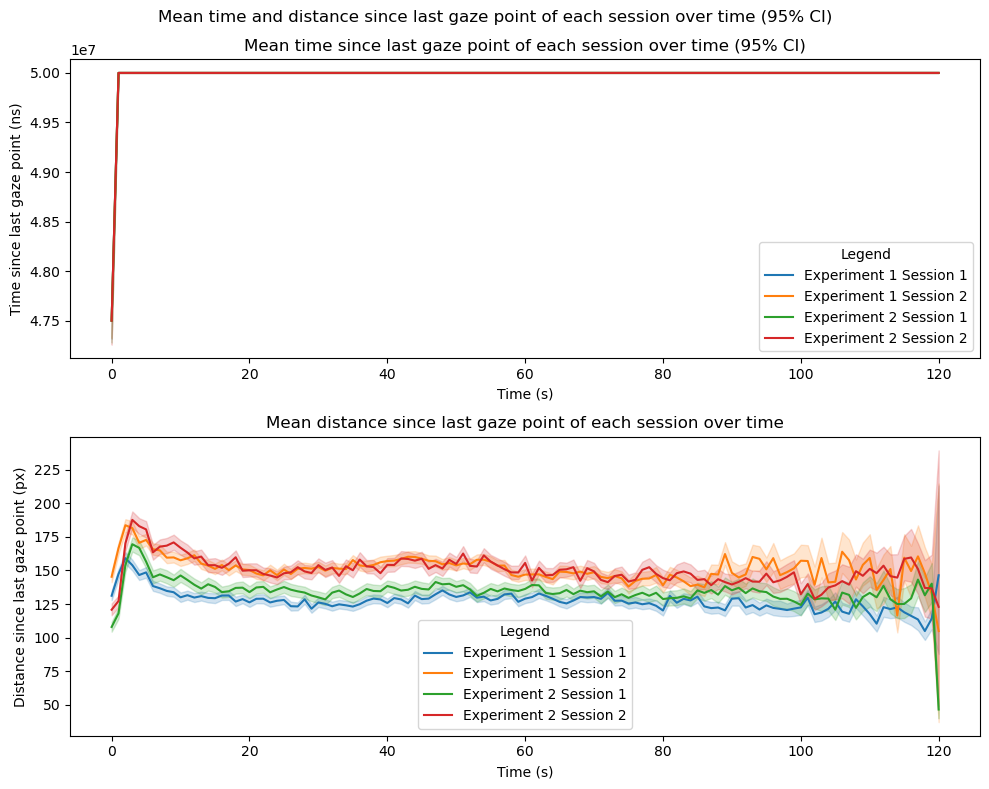

In [240]:
plot_gaze_distance_time_over_time(interpolated_data, remove_outliers=False)

## Gaze Speed Over Time

In [255]:
def plot_gaze_speed_over_time(
    data: pd.DataFrame,
) -> None:
    # Add the speed since last gaze point column
    data = data.copy()
    data = with_speed_since_last_column(data)
    data["TimeSinceStart_s"] = (
        data["TimeSinceStart_ns"] / N_NANOSECONDS_IN_SECOND
    ).astype(int)
    data["Legend"] = data.apply(
        lambda row: f"Experiment {int(row['ExperimentId'])} Session {int(row['SessionId'])}",
        axis=1,
    )

    # Plot the speed since last gaze point over time for all sessions
    plt.figure(figsize=(10, 4))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="SpeedSinceLast_pxs",
        errorbar=('ci', 95),
        label="Mean speed since last gaze point of all sessions",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.legend()
    plt.title(f"Mean speed since last gaze point of all sections over time (95% CI)")
    plt.tight_layout()
    plt.show()

    # Plot the speed since last gaze point over time for each session
    plt.figure(figsize=(10, 4))
    sns.lineplot(
        data=data,
        x="TimeSinceStart_s",
        y="SpeedSinceLast_pxs",
        errorbar=('ci', 95),
        hue="Legend",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Speed since last gaze point (px/s)")
    plt.title(f"Mean speed since last gaze point of each session over time (95% CI)")
    plt.tight_layout()
    plt.show()

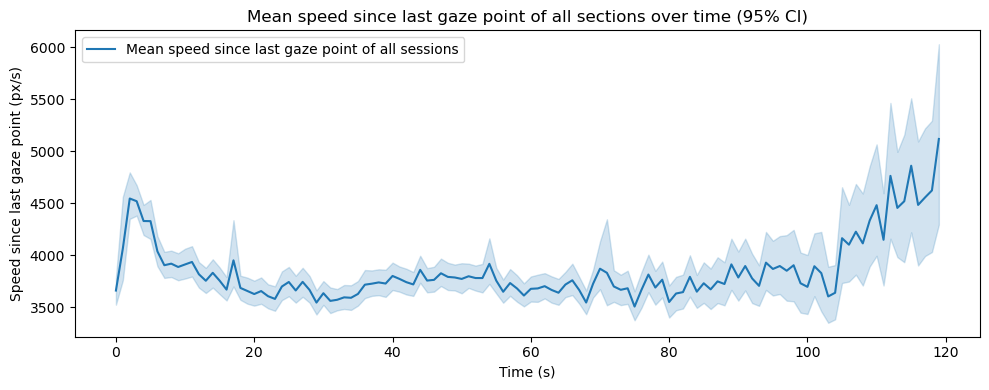

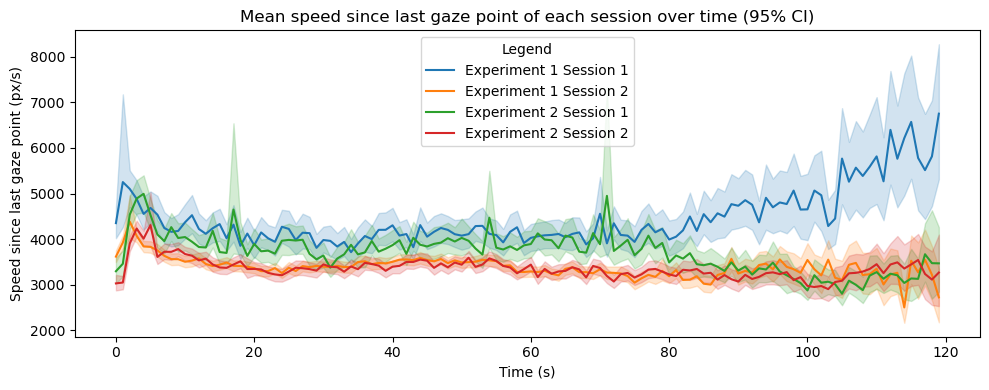

In [256]:
plot_gaze_speed_over_time(data)

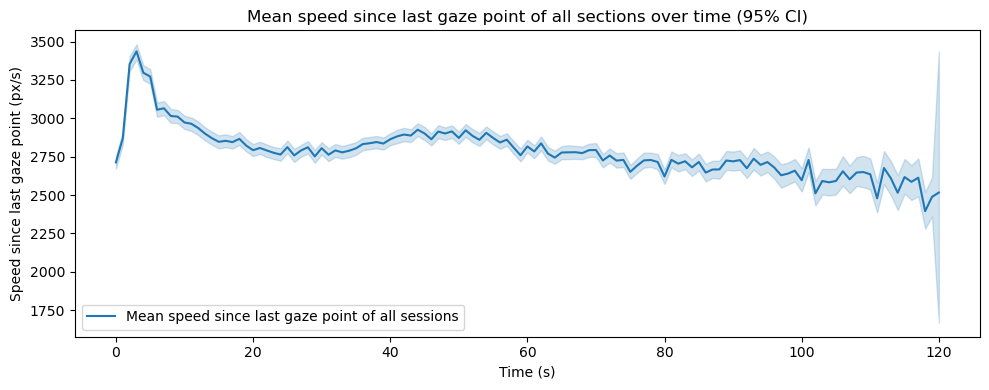

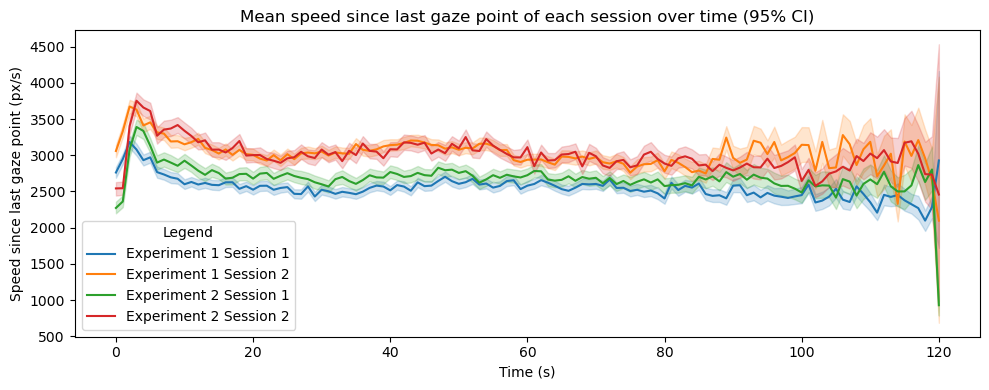

In [243]:
plot_gaze_speed_over_time(interpolated_data)

## Global Saliency Map

In [99]:
def plot_global_saliency(
    data: pd.DataFrame,
    n_samples = 10000,
) -> None:
    """
    Plot the global saliency of the data.

    Args:
        data (pd.DataFrame): The data to plot.
        n_samples (int, optional): The number of samples to plot. Defaults to 10000.
    """
    # Subsample the data
    data = data.copy()
    data = data.sample(n=n_samples)

    # Plot the global saliency
    plt.figure(figsize=(10, 6))
    ax = plt.gca()
    ax.set_facecolor("black")
    sns.kdeplot(
        data=data,
        x="GazeX_px",
        y="GazeY_px",
        fill=True,
        cmap="hot",
        levels=100,
        gridsize=100,
    )
    plt.xticks([])
    plt.xlabel("Gaze X")
    plt.yticks([])
    plt.ylabel("Gaze Y")
    plt.title("Global saliency heatmap")
    plt.tight_layout()
    plt.show()

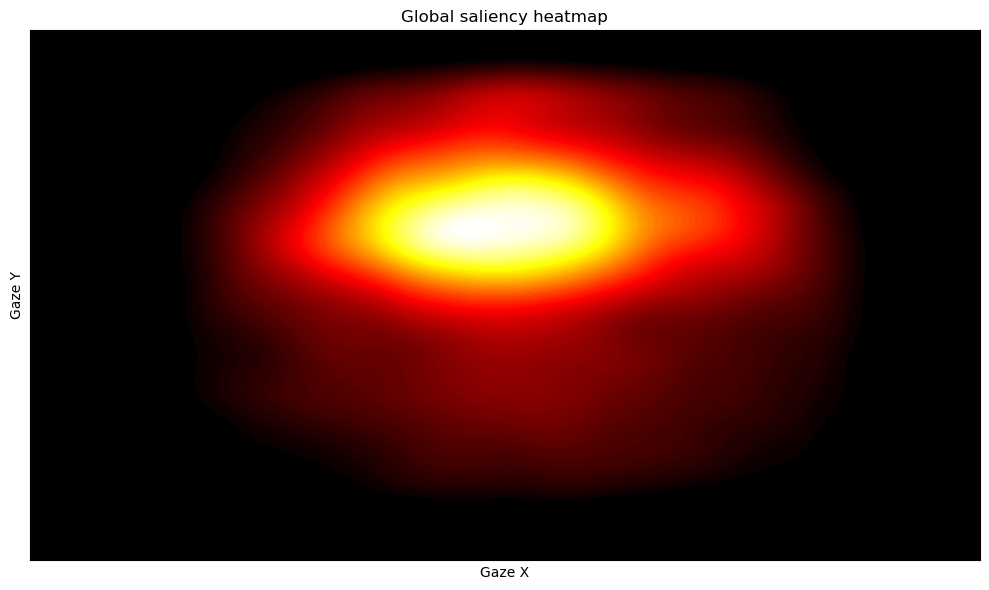

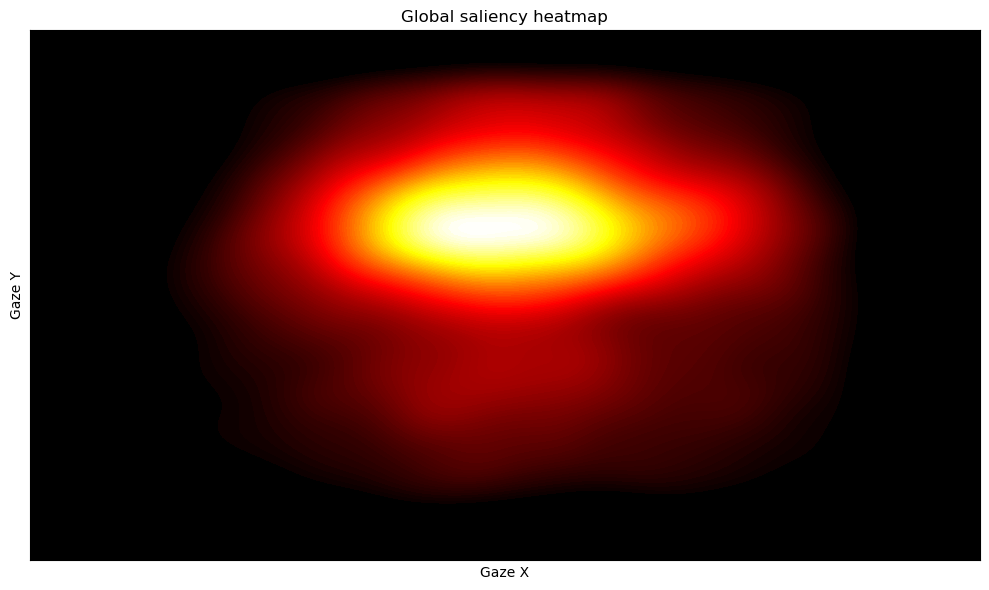

In [100]:
plot_global_saliency(data)
plot_global_saliency(interpolated_data)